# Brackett- and Paschen-Alpha subtraction

This notebook describes the PaA & BrA subtraction process to obtain continuum-only measurements in the F410M and F182M bands, and the subsequent subtraction of the remainder back from the PaA and BrA bands to obtain line-only images

In [1]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [2]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [3]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [4]:
from astropy.io import fits

In [5]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['font.size'] = 16

In [6]:
from astroquery.svo_fps import SvoFps

In [7]:
import numpy as np

In [8]:
import reproject

In [9]:
from astropy import units as u

In [10]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [11]:
fh_187 = fits.open(f'{basepath}/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb_i2d.fits')
fh_182 = fits.open(f'{basepath}/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb_i2d.fits')

In [12]:
ww187 = wcs.WCS(fh_187['SCI'].header)
ww182 = wcs.WCS(fh_182['SCI'].header)

Set OBSGEO-B to   -20.697594 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526831525.846 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [13]:
instrument = fh_187[0].header['INSTRUME']
telescope = fh_187[0].header['TELESCOP']
filt187 = fh_187[0].header['FILTER']
filt182 = fh_182[0].header['FILTER']
instrument, telescope, filt187, filt182

('NIRCAM', 'JWST', 'F187N', 'F182M')

In [14]:
wavelength_table_187 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt187}')
wavelength_table_182 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt182}')

In [15]:
filt187, filt182

('F187N', 'F182M')

In [16]:
waves_182 = wavelength_table_182['Wavelength']
trans_187 = np.interp(waves_182, wavelength_table_187['Wavelength'], wavelength_table_187['Transmission'])
trans_182 = wavelength_table_182['Transmission']

Text(0, 0.5, 'Transmission Fraction')

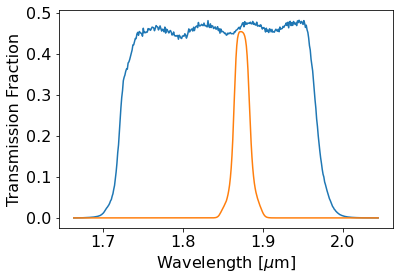

In [17]:
pl.plot(waves_182.to(u.um), trans_182)
pl.plot(waves_182.to(u.um), trans_187)
pl.xlabel("Wavelength [$\\mu$m]")
pl.ylabel("Transmission Fraction")

In [18]:
fh_405 = fits.open(f'{basepath}/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits')
fh_410 = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits')

In [19]:
ww405 = wcs.WCS(fh_405['SCI'].header)
ww410 = wcs.WCS(fh_410['SCI'].header)

Set OBSGEO-B to   -20.699629 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526855468.037 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [20]:
instrument = fh_405[0].header['INSTRUME']
telescope = fh_405[0].header['TELESCOP']
filt405 = fh_405[0].header['PUPIL']
wavelength_table_405 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt405}')
filt410 = fh_410[0].header['FILTER']
wavelength_table_410 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt410}')

In [21]:
filt405, filt410

('F405N', 'F410M')

In [22]:
waves_410 = wavelength_table_410['Wavelength']
trans_405 = np.interp(waves_410, wavelength_table_405['Wavelength'], wavelength_table_405['Transmission'])
trans_410 = wavelength_table_410['Transmission']

Text(0, 0.5, 'Transmission Fraction')

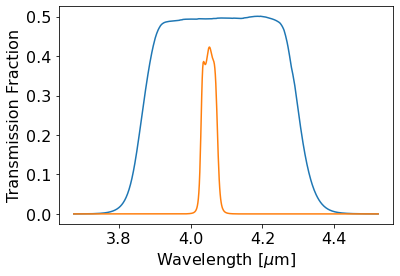

In [23]:
pl.plot(waves_410.to(u.um), trans_410)
pl.plot(waves_410.to(u.um), trans_405)
pl.xlabel("Wavelength [$\\mu$m]")
pl.ylabel("Transmission Fraction")

# Process

1. Subtract H-alpha line from continuum
  (this step implicitly assumes both have 'normalized' sensitivity, since all filters are calibrated to MJy/sr)
  
2. Re-calculate effective bandwidth of M-band

3. Scale M-band flux to the bandwidth of the H-alpha line

4. Subtract scaled value from original

Text(0, 0.5, 'NormalizedTransmission Fraction')

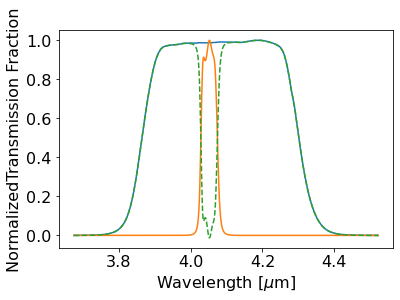

In [24]:
pl.plot(waves_410.to(u.um), trans_410/trans_410.max())
pl.plot(waves_410.to(u.um), trans_405/trans_405.max())
pl.plot(waves_410.to(u.um), trans_410/trans_410.max() - trans_405/trans_405.max(), linestyle='--')
pl.xlabel("Wavelength [$\\mu$m]")
pl.ylabel("NormalizedTransmission Fraction")

In [25]:
bw_orig = (np.diff(waves_410) * ((trans_410[:-1] + trans_410[1:])/2 / trans_410.max())).sum() * u.AA
bw_orig.to(u.um)

<Quantity 0.4378266 um>

In [26]:
resid_trans_410 = trans_410/trans_410.max() - trans_405/trans_405.max()
bw_410m405 = (np.diff(waves_410) * ((resid_trans_410[:-1] + resid_trans_410[1:])/2 / resid_trans_410.max())).sum() * u.AA
bw_410m405.to(u.um)

<Quantity 0.39225875 um>

In [27]:
bw_405 = (np.diff(waves_410) * ((trans_405[:-1] + trans_405[1:])/2 / trans_405.max())).sum() * u.AA
bw_405.to(u.um)

<Quantity 0.04567025 um>

The bandwidth of F410M - F405N is 0.392 $\mu$m, and the bandwidth of F405N is 0.046 $\mu$m, so we multiply the F410M by $W_{405} / W_{410m405}$

In [28]:
scale_factor_405to410 = bw_405 / bw_410m405
scale_factor_405to410

<Quantity 0.11642888>

Text(0, 0.5, 'Transmission Fraction')

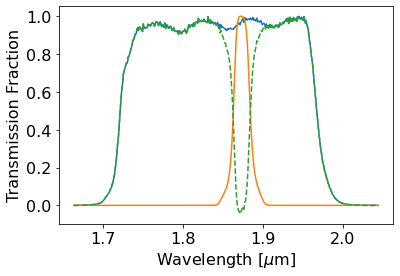

In [29]:
pl.plot(waves_182.to(u.um), trans_182/trans_182.max())
pl.plot(waves_182.to(u.um), trans_187/trans_187.max())
pl.plot(waves_182.to(u.um), trans_182/trans_182.max() - trans_187/trans_187.max(), linestyle='--')
pl.xlabel("Wavelength [$\\mu$m]")
pl.ylabel("Transmission Fraction")

In [30]:
bw_orig = (np.diff(waves_182) * ((trans_182[:-1] + trans_182[1:])/2 / trans_182.max())).sum() * u.AA
bw_orig.to(u.um)

<Quantity 0.23741965 um>

In [31]:
resid_trans_182 = trans_182/trans_182.max() - trans_187/trans_187.max()
bw_182m187 = (np.diff(waves_182) * ((resid_trans_182[:-1] + resid_trans_182[1:])/2 / resid_trans_182.max())).sum() * u.AA
bw_182m187.to(u.um)

<Quantity 0.21372924 um>

In [32]:
bw_187 = (np.diff(waves_182) * ((trans_187[:-1] + trans_187[1:])/2 / trans_187.max())).sum() * u.AA
bw_187.to(u.um)

<Quantity 0.0237447 um>

The bandwidth of F182M - F187N is 0.214 $\mu$m, and the bandwidth of F187N is 0.024 $\mu$m, so we multiply the F182M by $W_{187} / W_{182m187}$

In [33]:
scale_factor_187to182 = bw_187 / bw_182m187
scale_factor_187to182

<Quantity 0.11109708>

In [34]:
filterlist = SvoFps.get_filter_list(telescope, instrument)

In [35]:
filterlist

FilterProfileService,filterID,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,Description,Comments,WavelengthRef,WavelengthMean,WavelengthEff,WavelengthMin,WavelengthMax,WidthEff,WavelengthCen,WavelengthPivot,WavelengthPeak,WavelengthPhot,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
,,,,,,,,,,,,,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,erg s / (A cm2),,,Jy,,,,,
object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,object,float64,object,float64,object
ivo://svo/fps,JWST/NIRCam.F070W,Angstrom,em.wl,NIRCam,1,,NIRCam,JWST,https://jwst-docs.stsci.edu/display/JTI/NIRCam+Filters,,NIRCam F070W filter,"includes NIRCam optics, DBS, QE and JWST Optical Telescope Element",7039.1194650654,7088.3009369996,6988.4272768359,6048.1970523246,7927.0738659178,1212.8399166581,7099.1873443748,7039.1194650654,7691.5,7022.060805287,1430.8105961315,140.01772043307,JWST/NIRCam.F070W/Vega,Vega,2768.4045696982,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.php?ID=JWST/NIRCam.F070W
ivo://svo/fps,JWST/NIRCam.F090W,Angstrom,em.wl,NIRCam,1,,NIRCam,JWST,https://jwst-docs.stsci.edu/display/JTI/NIRCam+Filters,,NIRCam F090W filter,"includes NIRCam optics, DBS, QE and JWST Optical Telescope Element",9021.5288283376,9083.3952700859,8984.9812166695,7881.875216583,10243.081731613,1772.7418859059,9007.2449821231,9021.5288283376,9905.5,9026.3413455784,2088.0551132236,89.25825936013,JWST/NIRCam.F090W/Vega,Vega,2244.9507457345,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.php?ID=JWST/NIRCam.F090W
ivo://svo/fps,JWST/NIRCam.F115W,Angstrom,em.wl,NIRCam,1,,NIRCam,JWST,https://jwst-docs.stsci.edu/display/JTI/NIRCam+Filters,,NIRCam F115W filter,"includes NIRCam optics, DBS, QE and JWST Optical Telescope Element",11542.608442048,11623.884998948,11433.622503939,9975.6025121473,13058.39727876,2055.1323897044,11494.311055172,11542.608442048,12652.0,11488.863330367,2644.2460160212,53.032797973932,JWST/NIRCam.F115W/Vega,Vega,1746.1178757573,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.php?ID=JWST/NIRCam.F115W
ivo://svo/fps,JWST/NIRCam.F140M,Angstrom,em.wl,NIRCam,1,,NIRCam,JWST,https://jwst-docs.stsci.edu/display/JTI/NIRCam+Filters,,NIRCam F140M filter,"includes NIRCam optics, DBS, QE and JWST Optical Telescope Element",14053.232536752,14074.468174513,14023.618737895,13042.245240637,15058.576852755,1367.4001675902,14055.471891322,14053.232536752,14643.5,14037.805056945,1471.7453241243,34.081684124249,JWST/NIRCam.F140M/Vega,Vega,1288.6489399126,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.php?ID=JWST/NIRCam.F140M
ivo://svo/fps,JWST/NIRCam.F150W,Angstrom,em.wl,NIRCam,1,,NIRCam,JWST,https://jwst-docs.stsci.edu/display/JTI/NIRCam+Filters,,NIRCam F150W filter,"includes NIRCam optics, DBS, QE and JWST Optical Telescope Element",15007.438586148,15104.226607667,14872.561806926,13041.194700122,16948.894918849,2890.4253488344,15010.691851699,15007.438586148,16547.9,14937.56637456,3349.3001304998,28.954011369422,JWST/NIRCam.F150W/Vega,Vega,1172.057562686,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.php?ID=JWST/NIRCam.F150W
ivo://svo/fps,JWST/NIRCam.F162M,Angstrom,em.wl,NIRCam,1,,NIRCam,JWST,https://jwst-docs.stsci.edu/display/JTI/NIRCam+Filters,,NIRCam F162M filter,"includes NIRCam optics, DBS, QE and JWST Optical Telescope Element",16272.470828066,16296.590457303,16243.330063859,15126.159604123,17439.174281297,1626.2931600626,16279.44469614,16272.470828066,16954.0,16259.497388533,1710.0509900877,23.379801780551,JWST/NIRCam.F162M/Vega,Vega,1023.0385411698,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.php?ID=JWST/NIRCam.F162M
ivo://svo/fps,JWST/NIRCam.F164N,Angstrom,em.wl,NIRCam,1,,NIRCam,JWST,https://jwst-docs.stsci.edu/display/JT

# hummer & storey

recombination line ratios for different cases...

In [44]:
import requests
import gzip
from six import BytesIO
hsdata_resp = requests.get('https://cdsarc.cds.unistra.fr/ftp/VI/64/r1b0100.d.gz')
hsdata = gzip.decompress(hsdata_resp.content)

In [58]:
np.linspace(2, 13, 12, dtype='int')

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [53]:
lines = (hsdata.decode()).split('\n')

In [83]:
paa_emissivities = {}
paa_energy = (1.87*u.um).to(u.erg, u.spectral())
for logdensity in np.linspace(2, 13, 12, dtype='int'):
    header_line = f" E_NU= 4               Z= 1  TE= 1.000E+04  NE= 1.000E+{logdensity:02d}  CASE=B"
    indline = lines.index(header_line)
    #print(indline)
    nextline = indline+1
    paa_emissivities[logdensity] = float(lines[nextline].split()[-1]) * u.erg*u.cm**3/u.s# / paa_energy
paa_emissivities

{2: <Quantity 4.182e-26 cm3 erg / s>,
 3: <Quantity 4.158e-26 cm3 erg / s>,
 4: <Quantity 4.12e-26 cm3 erg / s>,
 5: <Quantity 4.062e-26 cm3 erg / s>,
 6: <Quantity 3.979e-26 cm3 erg / s>,
 7: <Quantity 3.875e-26 cm3 erg / s>,
 8: <Quantity 3.764e-26 cm3 erg / s>,
 9: <Quantity 3.787e-26 cm3 erg / s>,
 10: <Quantity 4.192e-26 cm3 erg / s>,
 11: <Quantity 5.089e-26 cm3 erg / s>,
 12: <Quantity 7.607e-26 cm3 erg / s>,
 13: <Quantity 1.294e-25 cm3 erg / s>}

In [84]:
bra_emissivities = {}
bra_energy = (4.05*u.um).to(u.erg, u.spectral())
for logdensity in np.linspace(2, 13, 12, dtype='int'):
    header_line = f" E_NU= 5               Z= 1  TE= 1.000E+04  NE= 1.000E+{logdensity:02d}  CASE=B"
    indline = lines.index(header_line)
    #print(indline)
    nextline = indline+1
    bra_emissivities[logdensity] = float(lines[nextline].split()[-1]) * u.erg*u.cm**3/u.s# / bra_energy
bra_emissivities

{2: <Quantity 9.906e-27 cm3 erg / s>,
 3: <Quantity 9.806e-27 cm3 erg / s>,
 4: <Quantity 9.648e-27 cm3 erg / s>,
 5: <Quantity 9.414e-27 cm3 erg / s>,
 6: <Quantity 9.093e-27 cm3 erg / s>,
 7: <Quantity 8.685e-27 cm3 erg / s>,
 8: <Quantity 8.246e-27 cm3 erg / s>,
 9: <Quantity 8.256e-27 cm3 erg / s>,
 10: <Quantity 9.163e-27 cm3 erg / s>,
 11: <Quantity 1.202e-26 cm3 erg / s>,
 12: <Quantity 1.912e-26 cm3 erg / s>,
 13: <Quantity 2.41e-26 cm3 erg / s>}

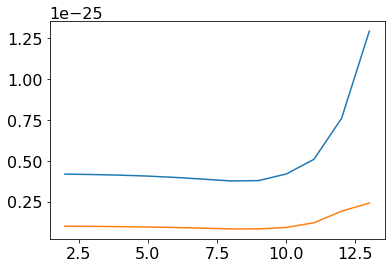

In [85]:
pl.plot(paa_emissivities.keys(), u.Quantity(list(paa_emissivities.values())))
pl.plot(bra_emissivities.keys(), u.Quantity(list(bra_emissivities.values())))

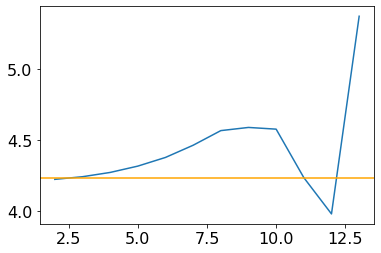

In [87]:
pl.plot(paa_emissivities.keys(), u.Quantity(list(paa_emissivities.values()))/u.Quantity(list(bra_emissivities.values())))
pl.axhline(4.23, color='orange')

In [88]:
hsdatahot_resp = requests.get('https://cdsarc.cds.unistra.fr/ftp/VI/64/r1b0300.d.gz')
hsdatahot_resp.raise_for_status()
hsdatahot = gzip.decompress(hsdatahot_resp.content)

In [92]:
lines_hot = (hsdatahot.decode()).split('\n')

In [93]:
paa_emissivities_hot = {}
paa_energy = (1.87*u.um).to(u.erg, u.spectral())
for logdensity in np.linspace(2, 13, 12, dtype='int'):
    header_line = f" E_NU= 4               Z= 1  TE= 3.000E+04  NE= 1.000E+{logdensity:02d}  CASE=B"
    indline = lines_hot.index(header_line)
    #print(indline)
    nextline = indline+1
    paa_emissivities_hot[logdensity] = float(lines[nextline].split()[-1]) * u.erg*u.cm**3/u.s# / paa_energy
paa_emissivities_hot

{2: <Quantity 4.182e-26 cm3 erg / s>,
 3: <Quantity 4.158e-26 cm3 erg / s>,
 4: <Quantity 4.12e-26 cm3 erg / s>,
 5: <Quantity 4.062e-26 cm3 erg / s>,
 6: <Quantity 3.979e-26 cm3 erg / s>,
 7: <Quantity 3.875e-26 cm3 erg / s>,
 8: <Quantity 3.764e-26 cm3 erg / s>,
 9: <Quantity 3.787e-26 cm3 erg / s>,
 10: <Quantity 4.192e-26 cm3 erg / s>,
 11: <Quantity 5.089e-26 cm3 erg / s>,
 12: <Quantity 7.607e-26 cm3 erg / s>,
 13: <Quantity 1.294e-25 cm3 erg / s>}

In [97]:
bra_emissivities_hot = {}
bra_energy = (1.87*u.um).to(u.erg, u.spectral())
for logdensity in np.linspace(2, 13, 12, dtype='int'):
    header_line = f" E_NU= 5               Z= 1  TE= 3.000E+04  NE= 1.000E+{logdensity:02d}  CASE=B"
    indline = lines_hot.index(header_line)
    #print(indline)
    nextline = indline+1
    bra_emissivities_hot[logdensity] = float(lines[nextline].split()[-1]) * u.erg*u.cm**3/u.s# / bra_energy
bra_emissivities_hot

{2: <Quantity 9.906e-27 cm3 erg / s>,
 3: <Quantity 9.806e-27 cm3 erg / s>,
 4: <Quantity 9.648e-27 cm3 erg / s>,
 5: <Quantity 9.414e-27 cm3 erg / s>,
 6: <Quantity 9.093e-27 cm3 erg / s>,
 7: <Quantity 8.685e-27 cm3 erg / s>,
 8: <Quantity 8.246e-27 cm3 erg / s>,
 9: <Quantity 8.256e-27 cm3 erg / s>,
 10: <Quantity 9.163e-27 cm3 erg / s>,
 11: <Quantity 1.202e-26 cm3 erg / s>,
 12: <Quantity 1.912e-26 cm3 erg / s>,
 13: <Quantity 2.41e-26 cm3 erg / s>}

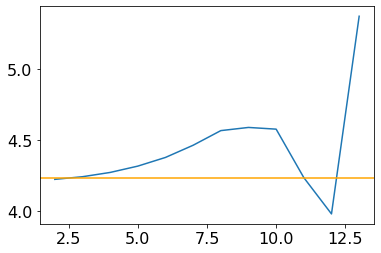

In [99]:
pl.plot(paa_emissivities_hot.keys(), u.Quantity(list(paa_emissivities_hot.values()))/u.Quantity(list(bra_emissivities_hot.values())))
pl.axhline(4.23, color='orange')